In [ ]:
!pip install scikit-optimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.0 MB/s 


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from yellowbrick.classifier import ROCAUC


# Configuração de gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)





## Configurações e Dataset

In [ ]:
# Carregando o dataset
mnist = keras.datasets.mnist

In [ ]:
# Extração dos dados de treino e teste
(X_treino_full, y_treino_full), (X_teste, y_teste) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# Explorando o dataset e transformações básicas

In [ ]:
# Shape
X_treino_full.shape

(60000, 28, 28)

In [ ]:
# Tipo dos dados
X_treino_full.dtype

dtype('uint8')

In [ ]:
# Ajustando tamanho 
X_test, X_train = X_treino_full[:5000] / 255., X_treino_full[5000:] / 255.
y_test, y_train = y_treino_full[:5000], y_treino_full[5000:]
X_teste = X_teste / 255.

In [ ]:
# Labels dados de treino
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
# Nomes das classes
classes_name = ["0", 
                 "1", 
                 "2", 
                 "3", 
                 "4", 
                 "5", 
                 "6", 
                 "7", 
                 "8", 
                 "9"]

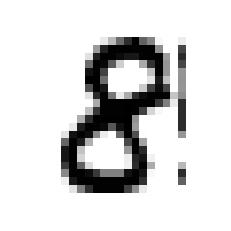

In [ ]:
# Plot de uma imagem
plt.imshow(X_train[9], cmap = "binary")
plt.axis('off')
plt.show()

In [ ]:
# Nome de classe
classes_name[y_train[9]]

'8'

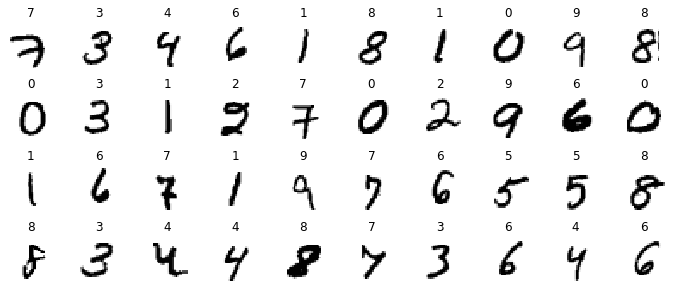

In [ ]:
# Plot de algumas imagens

# Vamos plotar 4 linhas e 10 coluns
n_rows = 4
n_cols = 10

# Área de plotagem
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

# Loop pelas linhas e colunas
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap = "binary", interpolation = "nearest")
        plt.axis('off')
        plt.title(classes_name[y_train[index]], fontsize = 12)

# Ajusta os plots
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

# # Salva a imagem em disco
# salva_imagem('plot_mnist', tight_layout = False)

# Mostra a imagem
plt.show()

In [ ]:
#reshape dataset de treino de para 2d, estava em 3d
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

In [ ]:
#reshape dataset de teste para 2d, estava em 3d
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [ ]:
#Verificando o balanceamento das classes 
unique, counts = np.unique(y_train, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)


[[   0 5444]
 [   1 6179]
 [   2 5470]
 [   3 5638]
 [   4 5307]
 [   5 4987]
 [   6 5417]
 [   7 5715]
 [   8 5389]
 [   9 5454]]


# Versão baseline do modelo

In [ ]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)


In [ ]:
model.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [ ]:
y_pred=model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


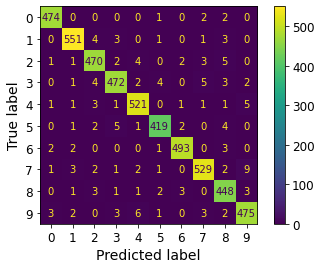

In [ ]:
#Plotando a matriz de confusão
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [ ]:
# Verificando a acurácia do modelo
accuracy_score(y_test, y_pred)

0.9704

In [ ]:
# Verificando outras métricas por classe
print(classification_report(y_test, y_pred, target_names=classes_name))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       479
           1       0.98      0.98      0.98       563
           2       0.96      0.96      0.96       488
           3       0.97      0.96      0.96       493
           4       0.97      0.97      0.97       535
           5       0.97      0.97      0.97       434
           6       0.98      0.98      0.98       501
           7       0.97      0.96      0.97       550
           8       0.95      0.97      0.96       462
           9       0.96      0.96      0.96       495

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



## Aplicando cross validation para melhorar o modelo

In [ ]:
scores = cross_val_score(model,X_train,y_train, cv=5, n_jobs=16)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.00


## Otimização de hiperparâmetros

In [ ]:
lgbm=lgb.LGBMClassifier(random_state=42)

In [ ]:
# Definição dos hiperparâmetros do modelo que serão testados 
param_grid = {
    'boosting_type': ['gbdt','dart','goss'],
    'n_estimators': (10, 200), 
    'max_depth': (1, 10),
    'loss': ['ls', 'lad', 'huber']
}

In [ ]:
#Iniciando a busca pelos melhores hiperparâmetros
search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_grid,
    scoring='accuracy',
    cv=5,
    n_iter=20,
    random_state=10,
    n_jobs=10,
    refit=True)

search.fit(X_train,y_train)

BayesSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=20,
              n_jobs=10, random_state=10, scoring='accuracy',
              search_spaces={'boosting_type': ['gbdt', 'dart', 'goss'],
                             'loss': ['ls', 'lad', 'huber'],
                             'max_depth': (1, 10), 'n_estimators': (10, 200)})

In [ ]:
# melhores hiperparâmetros selecionados

search.best_params_

OrderedDict([('boosting_type', 'goss'),
             ('loss', 'huber'),
             ('max_depth', 10),
             ('n_estimators', 200)])

In [ ]:
# melhor score

search.best_score_

0.9756545454545454

In [ ]:
# Dados dos demais modelos avaliados

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(20, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_loss,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1047.139789,3.181371,2.383127,0.873210,dart,huber,6,130,"{'boosting_type': 'dart', 'loss': 'huber', 'ma...",0.943818,0.949727,0.946909,0.942636,0.951727,0.946964,0.003434,14
1,646.362909,1.560150,3.969974,1.042238,goss,huber,8,124,"{'boosting_type': 'goss', 'loss': 'huber', 'ma...",0.971364,0.973273,0.969818,0.967455,0.973455,0.971073,0.002248,8
2,178.991531,0.511717,0.562160,0.169561,gbdt,lad,2,76,"{'boosting_type': 'gbdt', 'loss': 'lad', 'max_...",0.875182,0.884727,0.874909,0.882545,0.891727,0.881818,0.006308,20
3,172.436889,0.614976,1.572543,0.338509,goss,lad,2,149,"{'boosting_type': 'goss', 'loss': 'lad', 'max_...",0.912636,0.919818,0.912455,0.913455,0.925909,0.916855,0.005282,16
4,411.377867,1.199015,2.576377,0.305722,goss,lad,6,86,"{'boosting_type': 'goss', 'loss': 'lad', 'max_...",0.963909,0.965182,0.964000,0.960182,0.966636,0.963982,0.002142,11


## Modelo final

In [ ]:
#Criando um novo modelo com os hiperparâmetros indicados
final_model=lgb.LGBMClassifier(boosting_type= 'goss',loss= 'huber', max_depth= 10 , n_estimators= 200)

In [ ]:
final_model.fit(X_train,y_train)

LGBMClassifier(boosting_type='goss', loss='huber', max_depth=10,
               n_estimators=200)

In [ ]:
#Realizando as predições no conjunto de testes 
y_pred=final_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


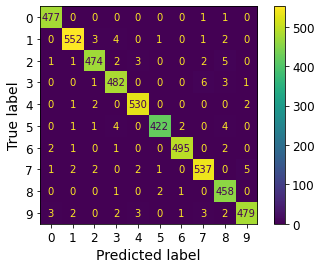

In [ ]:
#Plotando a matriz de confusão do novo modelo 
plot_confusion_matrix(final_model, X_test, y_test)  
plt.show()

In [ ]:
#acurácia do novo modelo
accuracy_score(y_test, y_pred)

0.9812

In [ ]:
# Verificando outras métricas por classe do novo modelo
print(classification_report(y_test, y_pred, target_names=classes_name))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       479
           1       0.99      0.98      0.98       563
           2       0.98      0.97      0.98       488
           3       0.97      0.98      0.97       493
           4       0.99      0.99      0.99       535
           5       0.99      0.97      0.98       434
           6       0.99      0.99      0.99       501
           7       0.98      0.98      0.98       550
           8       0.96      0.99      0.98       462
           9       0.98      0.97      0.98       495

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

